# Anomaly Detection Project
## By Carolyn Davis, Germain Cohort  
### October 22, 2021

### Project Spec: 
Answer questions regarding potential anomalies in the curriculum_log data for Codeups past and present students.
#### Questions:
- 1. Which lesson appears to attract the most traffic consistently across cohorts (per program)?
- 2. Is there a cohort that referred to a lesson significantly more than other cohorts seemed to gloss over?
- 3. Are there students who, when active, hardly access the curriculum? If so, what information do you have about these students?
- 4. What topics are grads continuing to reference after graduation and into their jobs (for each program)?
- 5. Which lessons are least accessed?

### Imports Utilized:

In [1]:
#module for removing pesky warnings
import warnings
warnings.filterwarnings("ignore")

#module for data manipulation
import pandas as pd

#module for acquiring curriculum log data from SQL database
import acquire as a 

#module for visualization of data
import matplotlib.pyplot as plt 

### Acquire Phase:
- Data is acquired from the curriculum_log database on SQL via Codeup permissions
- Functions for acquiring this data are stored in git under the file name acquire.py

In [2]:
df = a.get_curriculum_logs_data()

#### Quick Look at the Data:

In [3]:
df.shape

(847330, 15)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 847330 entries, 0 to 847329
Data columns (total 15 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   date        847330 non-null  object 
 1   time        847330 non-null  object 
 2   path        847329 non-null  object 
 3   user_id     847330 non-null  int64  
 4   cohort_id   847330 non-null  float64
 5   ip          847330 non-null  object 
 6   id          847330 non-null  int64  
 7   name        847330 non-null  object 
 8   slack       847330 non-null  object 
 9   start_date  847330 non-null  object 
 10  end_date    847330 non-null  object 
 11  created_at  847330 non-null  object 
 12  updated_at  847330 non-null  object 
 13  deleted_at  0 non-null       float64
 14  program_id  847330 non-null  int64  
dtypes: float64(2), int64(3), object(10)
memory usage: 97.0+ MB


In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
user_id,847330.0,456.707344,250.734201,1.0,263.0,476.0,648.0,981.0
cohort_id,847330.0,48.501049,32.795482,1.0,28.0,33.0,57.0,139.0
id,847330.0,48.501049,32.795482,1.0,28.0,33.0,57.0,139.0
deleted_at,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
program_id,847330.0,2.086004,0.388231,1.0,2.0,2.0,2.0,4.0


#### Initial Thoughts/Observations:
- Change columns: date, time, startdt, enddt to pd.datetime, however may not be necessary 
- Merge date and time cols and set as index
- Path defines lesson, table of contents ('/').json, html data usage, drop anthing not lesson
- Domain knowledge indicates ('/') is likely indicative of login page, not actual interaction with lessons
- Domain analysis indicates cohort id and id are keys and mean the same thing according to SQL, dropping one
- Ensure all numerics are conducive to methods to be performed on the data
- Program id supports domain knowledge of program type 1:PHP, 2:Java, 3:Data Science, 4:Front/End, change program id 
    id values to reflect this for readibility
- Peep name for label analysis in congruence with numeric data
- Initial column drop: Slack column seems pointless..likely drop, along with creation and deleted_at cols
- Start_date and end_date will likely tell the best story for anomalies implies activity outside normal population activity for students

### Preparation Phase:

In [6]:
#First dropping the columns that after initial exploration seem irrelevant for project spec

#assign columns that will be deleted to variable
initial_drop = ['id', 'created_at', 'deleted_at', 'slack']

#drop the columns assigned to the above variable
df = df.drop(columns=(initial_drop))

#visualize and check that changes were successful
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 847330 entries, 0 to 847329
Data columns (total 11 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   date        847330 non-null  object 
 1   time        847330 non-null  object 
 2   path        847329 non-null  object 
 3   user_id     847330 non-null  int64  
 4   cohort_id   847330 non-null  float64
 5   ip          847330 non-null  object 
 6   name        847330 non-null  object 
 7   start_date  847330 non-null  object 
 8   end_date    847330 non-null  object 
 9   updated_at  847330 non-null  object 
 10  program_id  847330 non-null  int64  
dtypes: float64(1), int64(2), object(8)
memory usage: 71.1+ MB


#### Convert program_id column to labeled programs in str format:

In [8]:
#converting the program_id column from a int to a str 
df['program_id'] = df['program_id'].astype(str)

#making four new columns for each program id and converting integers to strings that are easy to identify
df['program_id'] = df['program_id'].str.replace('1', 'php').str.replace('2', 'java').str.replace('3', 'ds').str.replace('4', 'fe')

#check df to ensure changes were successful
df.head()

,date,time,path,user_id,cohort_id,ip,name,start_date,end_date,updated_at,program_id
0,2018-01-26,09:55:03,/,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,php
1,2018-01-26,09:56:02,java-ii,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,php
2,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,php
3,2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,php
4,2018-01-26,09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61,Teddy,2018-01-08,2018-05-17,2018-01-08 13:59:10,java


### Tackling Questions of Interest:

#### - Question 1: Which lesson appears to attract the most traffic consistently across cohorts (per program)?

#### Plan:
- Need a copy of the original df for comparison
- Assuming rows in the path column of the df with the value '/' are not indicative of lesson activity while students are accessing the curriculum 
- ('/')'s will not be included in the analysis of student-lesson traffic

In [9]:
q1_df = df.copy()

In [11]:
#eliminates instances of user activity where curriculum is not accessed
q1_df = q1_df[q1_df['path'].str.len() > 2]

#assigning lesson groupings for student activity to the variable counts for number of students accessing curriculum 
counts = q1_df['path'].value_counts()

#looking at the value_counts for each lesson most frequently visited by students
counts.head(3)

javascript-i                18203
toc                         17591
search/search_index.json    17534
Name: path, dtype: int64

<AxesSubplot:>

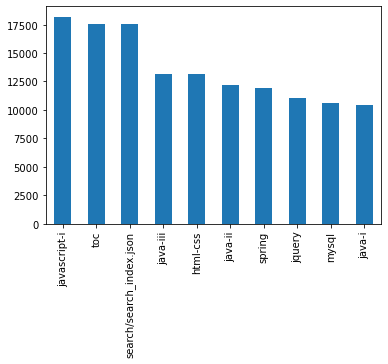

In [12]:
#Visualize the Counts in the Bar Chart
counts.head(10).plot.bar()

#### Observations/Takeaways:
- The lesson 'javascript-i' appears to be the most frequently trafficked site across all programs in the Codeup curriculum log database
- Following the most visited, the lessons known as 'TOC' and 'search/search_index.json' are the two runner-ups for most frequently trafficked sites.

##### Additional Thought:
- Based off analysis of the domain, it is my theory that .json maybe indicative of web-scraping activity. If I have sufficient time, this theory will be explored further.

### Question 2: Is there a cohort that referred to a lesson significantly more than other cohorts seemed to gloss over?

#### Plan:
- Analyze lesson activity across all cohorts, by finding the max value_counts for each lesson across the cohorts
- Set the index to cohort id, to maintain axis
- Identify lesson and cohort that trafficked specific lesson, significantly more than others

In [13]:
#looking at the value counts by cohort and path activity across cohorts
q2_grouping = q1_df.groupby('path')['cohort_id'].value_counts()
q2_grouping.head()

path                              cohort_id
%20https://github.com/RaulCPena   55.0         1
,%20https://github.com/RaulCPena  55.0         1
.git                              24.0         1
.gitignore                        24.0         1
                                  59.0         1
Name: cohort_id, dtype: int64

In [18]:
#renaming second path column (not shown above) to 'counts'
q2_grouping = q2_grouping.rename('counts')

#check it out
print(q2_grouping.head().T)

path                              cohort_id
%20https://github.com/RaulCPena   55.0         1
,%20https://github.com/RaulCPena  55.0         1
.git                              24.0         1
.gitignore                        24.0         1
                                  59.0         1
Name: counts, dtype: int64


In [20]:
#reset the index so we can set it in the next step
q2_grouping = q2_grouping.reset_index()

#set the index to cohort_id to get lesson traffic for each cohort
q2_grouping = q2_grouping.set_index('cohort_id')

#Sort values for max counts sorts descending
q2_grouping = q2_grouping.sort_values(by='counts', ascending=False)

#Visualize Cohort grouping based off most traffic lesson counts
q2_grouping.head()

,path,counts
cohort_id,,
62.0,toc,1866
28.0,javascript-i,1817
56.0,search/search_index.json,1497
29.0,toc,1465
28.0,spring,1403


#### It appears we have some top contenders, with TOC being the most visited lesson path by cohort_id 62.0, followed by some closed contenders for other frequently visited lesson paths. Push forward with visualizing.

<AxesSubplot:xlabel='cohort_id'>

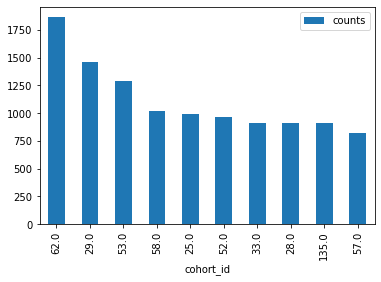

In [21]:
#filtering grouping to just look at top cohort activity for just the lesson path 'toc'
q2_grouping = q2_grouping[q2_grouping['path'] == 'toc']

#visualizing cohort activity for the toc lesson path across all cohorts
q2_grouping.head(10).plot.bar()

### Takeaways:
- With reference to the cohorts.csv provided in this project's relevant git repo, it is apparent that cohort_id 62.0, also known as the Jupiter cohort visited the lesson 'toc' significantly more than any other cohort and any other lesson overall for all students accessing these curriculum logs.
- With reference to the visualiztion for 'TOC' lesson access for all cohorts, the cohort_id 29.0 is identified as staff logs for this particular lesson. This is to be suspected, given need for continous access to the curriculum.
- With more time, it would interesting to explore more why, cohort Jupiter accessed this lesson more than any other lesson, more than even the staff across all historical cohorts. 

### Question 3: Are there students who, when active, hardly access the curriculum? If so, what information do you have about these students?

#### Plan:
- It has been established based off the research done prior on the data for this domain, that the value ('/') found in the path column will be treated as logged on but not presently accessing the curriculum.
- This logic is based off the lack of file path values following instances of this value in the path column.
- The instances of no activity by students will then be compared to overall activity for each student.
- The number of counts of inactivity will be divide by overall lesson activity to achieve the activity ratio.
- The higher the ratio, the higher the liklihood, that the student is logged on but not actually the lesson curriculum

In [22]:
#if the len is less than two, than the path is not a lesson accessed by the student
q3_slashes = df[df['path'].str.len() < 2]

#looking at the value_counts for each existence of slash presence in the path column
q3_slashes['path'].value_counts()

#checking that the path column only possess slashes indicating instances of inactivity for lesson access
q3_slashes.head()

,date,time,path,user_id,cohort_id,ip,name,start_date,end_date,updated_at,program_id
0,2018-01-26,09:55:03,/,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,php
12,2018-01-26,10:00:37,/,6,22.0,97.105.19.61,Teddy,2018-01-08,2018-05-17,2018-01-08 13:59:10,java
30,2018-01-26,10:14:47,/,11,1.0,97.105.19.61,Arches,2014-02-04,2014-04-22,2016-06-14 19:52:26,php
32,2018-01-26,10:14:53,/,6,22.0,97.105.19.61,Teddy,2018-01-08,2018-05-17,2018-01-08 13:59:10,java
39,2018-01-26,10:18:22,/,10,21.0,97.105.19.61,Sequoia,2017-09-27,2018-02-15,2017-09-27 20:22:41,java


In [23]:
#assigns variable to rows containing slash in the column 'path' for use
q3_slashes = q3_slashes[q3_slashes['path'] == '/']


In [24]:
#any rows in the path column with a length greater than two will be considered lessons
q3_unslashes = df[df['path'].str.len() > 2]

In [25]:
#visualize the groupings for students not actually accessing curriculum
q3_grouping = q3_slashes.groupby('path')['ip'].value_counts()

#renaming the new column states as ip to counts for further analysis
q3_grouping = q3_grouping.rename('counts')

#check out the slash groupings
q3_grouping.head()

path  ip             
/     97.105.19.58       10912
      97.105.19.61        2875
      71.150.217.33        448
      192.171.117.210      446
      76.185.145.231       407
Name: counts, dtype: int64

In [26]:
#reset the index so we can set the index
q3_grouping = q3_grouping.reset_index()

#set index to unique identifier for each student 'ip'
q3_grouping = q3_grouping.set_index('ip')

#drop col path it is no longer relevant
q3_grouping = q3_grouping.drop(columns=['path'], axis=1)

#check it out
q3_grouping.head()

,counts
ip,
97.105.19.58,10912
97.105.19.61,2875
71.150.217.33,448
192.171.117.210,446
76.185.145.231,407


#### Quick Takeaway:
- It appears the top student with the ip address ending in '58' is accessing the the Codeup curriculum login page a lot.
- This could be suspicious, this can be cleared up by checking out this students activity with the curriculum's lessons. An anomaly may be presented if the lesson activity is significantly less than login page activity as defined with with ('/')'s seen in the path column. Moving forward...

In [27]:
#assigning all activity that is not a slash to its own col for overall activity comparison for the student
q3_div = q3_unslashes['ip'].value_counts()

#renaming value_counts to div for divide marker of overall lesson activity for student
q3_div = q3_div.rename('div')

In [28]:
#concat the two new value count columns into one df, maintianing index integrity for exploring
q3_all = pd.concat([q3_grouping, q3_div], axis=1)
q3_all.head()

,counts,div
97.105.19.58,10912.0,257736.0
97.105.19.61,2875.0,57655.0
71.150.217.33,448.0,6342.0
192.171.117.210,446.0,8678.0
76.185.145.231,407.0,4347.0


In [29]:
#make new col for activity ration based off homepage activity(no lessons) 
# in comparison to all curriculum access based off student ip
q3_all['activity'] = q3_all['counts'] / q3_all['div']
q3_all


,counts,div,activity
97.105.19.58,10912.0,257736.0,0.042338
97.105.19.61,2875.0,57655.0,0.049866
71.150.217.33,448.0,6342.0,0.070640
192.171.117.210,446.0,8678.0,0.051394
76.185.145.231,407.0,4347.0,0.093628
...,...,...,...
172.58.107.192,NaN,1.0,NaN
50.24.136.80,NaN,1.0,NaN
99.203.90.177,NaN,1.0,NaN
166.251.109.47,NaN,1.0,NaN


In [30]:
#found some nulls, lets drop those real quick, and move on
q3_all = q3_all.dropna()
q3_all

,counts,div,activity
97.105.19.58,10912.0,257736.0,0.042338
97.105.19.61,2875.0,57655.0,0.049866
71.150.217.33,448.0,6342.0,0.070640
192.171.117.210,446.0,8678.0,0.051394
76.185.145.231,407.0,4347.0,0.093628
...,...,...,...
99.52.78.67,1.0,7.0,0.142857
99.57.20.163,1.0,2.0,0.500000
99.62.48.254,1.0,110.0,0.009091
99.66.104.96,1.0,2.0,0.500000


In [31]:
#Any IP with login count ('/') less than 20 is hypothesized to be suspicious, based off domain knowledge
q3_all = q3_all[q3_all['counts'] > 20]

#Only looking at the top 10 activity ratios for students 
q3_all['activity'].head(10)

#sort the values descending from max activity counts to see top performers 
q3_all = q3_all.sort_values(by='activity', ascending=False)
q3_all

,counts,div,activity
108.78.170.79,22.0,18.0,1.222222
24.26.254.147,132.0,148.0,0.891892
67.11.56.165,37.0,65.0,0.569231
70.123.227.169,29.0,62.0,0.467742
136.50.3.247,131.0,405.0,0.323457
...,...,...,...
172.124.67.93,58.0,3453.0,0.016797
47.187.240.67,23.0,1448.0,0.015884
24.243.67.104,38.0,3194.0,0.011897
72.179.164.139,27.0,2402.0,0.011241


<AxesSubplot:>

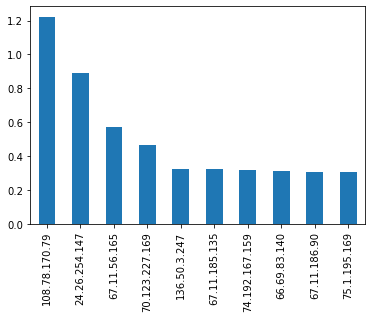

In [32]:
#visualize the activity ratios for students accessing and lack of curriculum use
q3_all['activity'].head(10).plot.bar()

### Takeaways:
- The Student identified with an ending IP address of .79 is possibly logging in to the Codeup curriculum but not really accessing the lessons as extensively as expected. This could be due to nefarious intentions such as web-escaping or may have desktop search engine set to constantly refresh which could be causing this strange activity ratio.
- With more time it would be fitting to dive deeper into the timestamps associated with this students activity. This may provide evidence of why the student is logging on more than actually accessing the Codeup curriculum.

### Question 4:  What topics are grads continuing to reference after graduation and into their jobs (for each program)?

#### Plan:
- Filter currciulum_log data to just activity logged after students' assigned graduation dates (end_date),
- Perform groupby on lesson (path) and program for grouping analysis.

In [34]:
#make a copy of the q1_df that filters out path logs with just ('/') indicating not active in lessons
after_grad_df = q1_df.copy() 

#only look at lesson access in path column for students that have graduated
after_grad_df = after_grad_df[after_grad_df['date'] > after_grad_df['end_date']]

#Check out the activity of lesson activity for programs
q4_grouping = after_grad_df.groupby('program_id')['path'].value_counts()
q4_grouping

program_id  path                                          
ds          search/search_index.json                          493
            sql/mysql-overview                                275
            classification/overview                           266
            classification/scale_features_or_not.svg          219
            anomaly-detection/AnomalyDetectionCartoon.jpeg    193
                                                             ... 
php         students                                            1
            students/468/notes                                  1
            students/units/75/sub_units/268                     1
            teams/13                                            1
            uploads/58a217a705bde.jpg                           1
Name: path, Length: 2799, dtype: int64

In [35]:
#rename second path col that populates to 'counts'
q4_grouping = q4_grouping.rename('counts')

#reset the index 
q4_grouping = q4_grouping.reset_index()

In [37]:
#using a little dictionary comprehension to assign date to the four program_ids for this data
keys = list(q4_grouping['program_id'].unique())

#assigning activity for students within each program to the counts of lesson activity post graduation
df_split = {key: q4_grouping[q4_grouping['program_id'] == key].sort_values(by= 'counts', ascending=False).head(3).set_index('path') for key in keys}
df_split


{'ds':                          program_id  counts
 path                                       
 search/search_index.json         ds     493
 sql/mysql-overview               ds     275
 classification/overview          ds     266,
 'fe':                                             program_id  counts
 path                                                          
 content/html-css                                    fe       2
 content/html-css/gitbook/images/favicon.ico         fe       1
 content/html-css/introduction.html                  fe       1,
 'java':                          program_id  counts
 path                                       
 javascript-i                   java    4229
 spring                         java    3760
 search/search_index.json       java    3562,
 'php':              program_id  counts
 path                           
 index.html          php    1011
 javascript-i        php     736
 html-css            php     542}

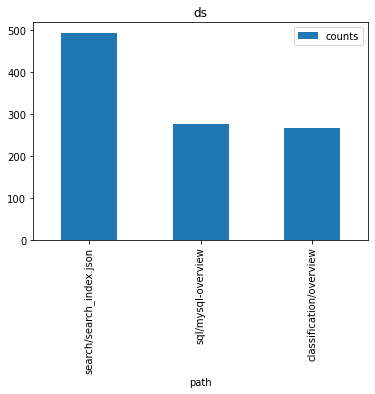

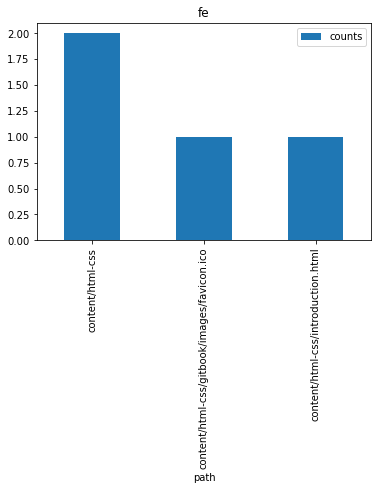

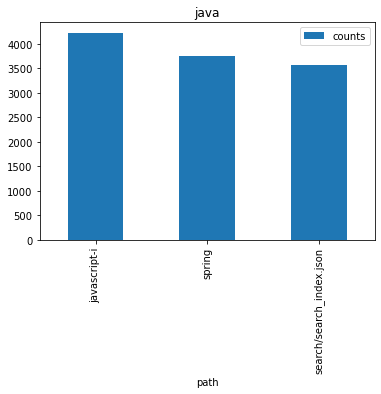

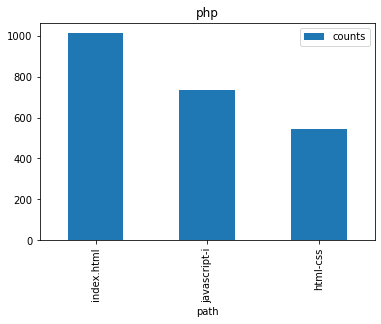

In [38]:
#Let's visualize a more informative picture..

for program, df in df_split.items():
    df.plot.bar(title=program)
    plt.legend()
    plt.show()
    plt.close()

### Takeaways:
- The Data Science program is accessing the search_index path quite extensively post graduation. As aforementioned, this could be potentially attributed to web-scraping activity.
- The Front End program graduates are accessing the content/htm-css lesson extensively more than any other lesson following their term with Codeup.
- The Java Program is referring back to the javascript-i lesson the most post gradation.
- The PHP Full Stack program refers back most to the index.html lesson quite extensiviely after Codeup. 
- Again, with more time looking at these consistent reoccurences for potential webscaping, would be provide more confidence in these conclusions.

### Question 5: Which lessons are least accessed?

#### Plan:
- Perform the same steps as listed above for question 4, but instead look at the minimum occurrence of lesson activity within the path column.

In [39]:
#new variable using df for just post grad lesson activity
q5_grouping = after_grad_df.groupby('program_id')['path'].value_counts()

#Renaming the second path column again to counts to grouping readibility
q5_grouping = q5_grouping.rename('counts')
q5_grouping

program_id  path                                          
ds          search/search_index.json                          493
            sql/mysql-overview                                275
            classification/overview                           266
            classification/scale_features_or_not.svg          219
            anomaly-detection/AnomalyDetectionCartoon.jpeg    193
                                                             ... 
php         students                                            1
            students/468/notes                                  1
            students/units/75/sub_units/268                     1
            teams/13                                            1
            uploads/58a217a705bde.jpg                           1
Name: counts, Length: 2799, dtype: int64

In [40]:
#reset the index 
q5_grouping = q5_grouping.reset_index()

In [41]:
#using a little dictionary comprehension to assign date to the four program_ids for this data
keys = list(q5_grouping['program_id'].unique())

#assigning activity for students within each program to the counts of lesson activity post graduation
df_split = {key: q5_grouping[q5_grouping['program_id'] == key].sort_values(by= 'counts', ascending=False).tail(3).set_index('path') for key in keys}


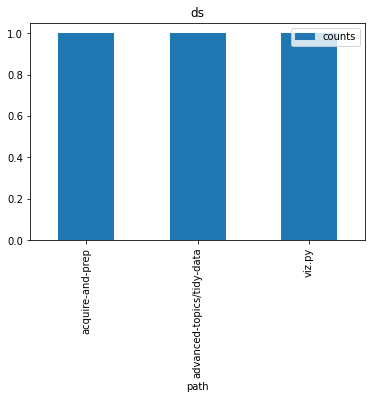

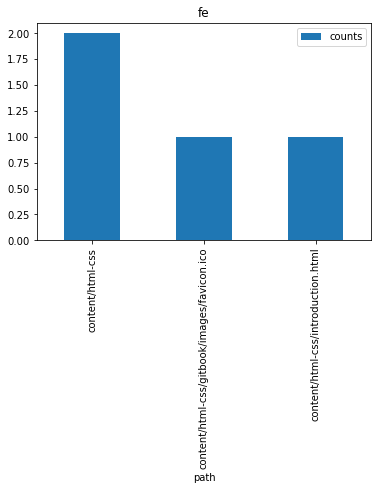

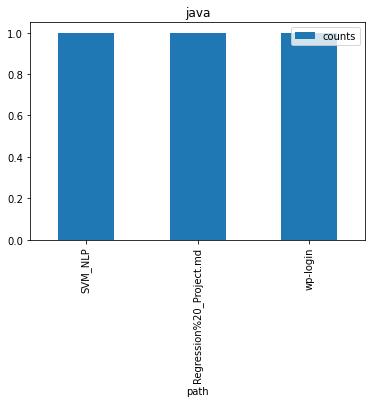

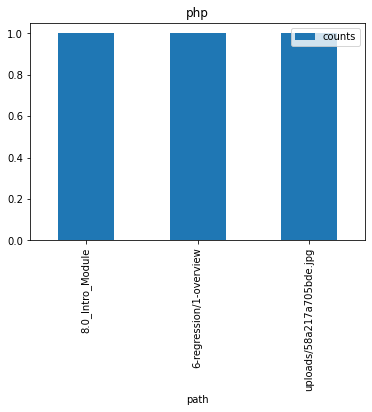

In [42]:
#Let's visualize a more informative picture..
for program, df in df_split.items():
    df.plot.bar(title=program)
    plt.legend()
    plt.show()
    plt.close()

### Takeaways: Least Visited Lesson Post Graduation
- Data Science Program: acquire/prepare, advanced-topics, and viz.py
- Front End Program: content/html-css, content/html-css... (see above viz), and content/html-css..introduction.html
- Java Program: SVM/nlp, Regression%20.., and wp-login
- PHP Full Stack Program: 8.0_Intro_Module, 6-regression/1-overview, and upload/58a217a705bde.jpg

## Final Conclusions and Recommendations:
- There was quite a bit of domain knowledge that should be further researched to solidfy initial conclusions and takeaways established in this project.
- Theories regarding web-scraping activity providing through path instance of '.html,.json,etc' should be visited with further exploration into pattern of life exploration. I would look further into timestamp and date activity for these relevant IP addresses and draw further conclusions.
- Each question answered provided a basis for a deeper dive into IP addresses that provided some anomalistic behavior.